# Clustering Fake News

In [1]:
!pip install -r requirements.txt

import re
import matplotlib.pyplot as plt
import requests
from bs4 import BeautifulSoup
import json
from pylab import *
import pandas as pd
from dogues_functions_2 import clean_article_name, plot_category_trends, fetch_pageview_count, normal_data, extract_clean_text, fetch_and_combine_pageview_data, scrape_wikipedia_sub_subheadings_with_links, fetch_pageview_count_dates, fetch_viewcount_df


from sklearn.feature_extraction.text import CountVectorizer
from sklearn.feature_extraction.text import ENGLISH_STOP_WORDS
from nltk.stem import PorterStemmer
import pandas as pd
import re

from matplotlib.dates import DateFormatter, AutoDateLocator
from datetime import datetime
from supersmoother import SuperSmoother

from sklearn.metrics import jaccard_score
from matplotlib_venn import venn2

## Helper functions

In [2]:
# Function for text preprocessing (remove non-alphabetic characters, remove stopwords, lowercase, and stemming)

def preprocess_text(text):
    ps = PorterStemmer()
    stop_words = ENGLISH_STOP_WORDS
    words = re.findall(r'\b\w+\b', text.lower())
    filtered_words = [ps.stem(word) for word in words if word not in stop_words]
    return filtered_words


In [3]:
# Function to generate BoW 

def generate_bow_for_heading(df, heading):
    
    # Filter misinformation DataFrame for the specific heading
    misinformation_subset = df[df['Main Heading'] == heading]
    misinformation_subset = misinformation_subset.dropna()
    
    misinformation_text = misinformation_subset[['Sub-subheading', 'Subheading', 'Main Heading']].apply(
    lambda x: ' '.join(x.dropna().astype(str)), axis=1
)
    misinformation_text = misinformation_text.dropna()
    misinformation_words_preprocessed = misinformation_text.apply(preprocess_text)
    
  
    
    # Manually remove specific words from the list
    words_to_remove = ['19', 'covid', 'cov', '2020', '2019', 'viru', 'use', 'hot','face', 
                   'count', 'urin', 'oil', 'govern','nation', 'state', 'spread', 'heal', 
                       'gain', 'world', 'report', 'medic', 'countri', 'death', 'news', 
                       'diseas','safe','immun','transmiss','larg', 'base', 'prevent', 'treatment', 'flu', 
                      'bodi', 'remain','predict', 'chloroquin','popul']
    misinformation_flat_words = [
    word for words_list in misinformation_words_preprocessed for word in words_list if word not in words_to_remove
    ]
    # Create a CountVectorizer instance
    vectorizer = CountVectorizer()

    # Fit and transform the preprocessed words to obtain the BoW matrix
    X_bow_misinformation = vectorizer.fit_transform([' '.join(misinformation_flat_words)])

    # Access the feature names (words)
    feature_names = vectorizer.get_feature_names()
    #print(feature_names)

    # Convert the BoW matrix to a DataFrame for easier exploration
    bow_misinformation_df = pd.DataFrame(X_bow_misinformation.toarray(), columns=feature_names)


    return bow_misinformation_df, feature_names


In [4]:
#Function to plot the categories as pie charts by language

def plot_subcategory_pie(subcategory_counts_by_heading, tot_news):
    num_headings = len(subcategory_counts_by_heading)

    # Determine the number of rows and columns for the grid
    if num_headings <= 6:
        nrows, ncols = 2, 3
    else:
        nrows, ncols = 3, 3

    # Plot the charts in a grid
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(15, 10))

    # Iterate over the headings
    for i, (heading, subcategory_counts) in enumerate(subcategory_counts_by_heading.items()):
        if i == 6:
            break  # Stop after the first 6 headings

        row = i // 3
        col = i % 3

        
        axes[row, col].pie(subcategory_counts, labels=subcategory_counts.index, autopct='%1.1f%%', startangle=140)
        axes[row, col].set_title(f'{heading}\n{round(subcategory_counts.sum()/tot_news* 100)} % of news')

    # Plot the last chart in the center of the last row if there are 7 headings
    if num_headings == 7:
        last_heading, last_subcategory_counts = list(subcategory_counts_by_heading.items())[-1]
        axes[2, 1].pie(last_subcategory_counts, labels=last_subcategory_counts.index, autopct='%1.1f%%', startangle=140)
        axes[2, 1].set_title(f'{last_heading}\n{round(last_subcategory_counts.sum()/tot_news* 100)} % of news')
        fig.delaxes(axes[2, 2])
        fig.delaxes(axes[2, 0])

    plt.tight_layout()
    plt.show()


In [25]:
# Function to cluster news based on bow
def clustering_lang(main_df, tot_news):
    subcategory_counts_by_heading = {}
    all_filtered_dfs = []  

    for heading, data in heading_bow_dict.items():
        # Extract the BoW DataFrame and feature names from the dictionary
        bow_df = data['heading']
        feature_names = data['feature_names']

        # Create a new column 'Subcategory' and set it to be the word if the word is present in the 'claim' column,
        # otherwise set it to an empty list
        main_df['Subcategory'] = main_df['claim'].apply(lambda x: [word for word in feature_names if word in str(x).lower()]).copy()

        # Filter the DataFrame to include only the classified rows
        filtered_df = main_df[main_df['Subcategory'].apply(lambda x: bool(x))].copy()
        filtered_df['Subcategory'] = filtered_df['Subcategory'].apply(lambda x: ', '.join(x))
        filtered_df['Subcategory'] = filtered_df['Subcategory'].apply(lambda x: category_mapping.get(x, x))

        # Create a new column 'Main heading' as a list containing the current heading
        filtered_df['Main heading'] = [[heading] for _ in range(len(filtered_df))]

        # Print the number of classified news for the current heading
        print(f"Number of classified news for {heading}: {len(filtered_df)}")

        # Print the top categories for the current heading
        category_counts = filtered_df['Subcategory'].value_counts()
        #category_counts = category_counts.sort_values(ascending=False)
        top_categories = category_counts.head(10)

        # Store subcategories and their counts for each heading
        subcategory_counts_by_heading[heading] = top_categories

        # Append the filtered_df to the list
        all_filtered_dfs.append(filtered_df)

    # Concatenate all the filtered DataFrames for each heading
    final_filtered_df = pd.concat(all_filtered_dfs, ignore_index=True)

    # Drop the 'Subcategory' column as it's no longer needed
    main_df.drop('Subcategory', axis=1, inplace=True)

    # Save the final_filtered_df DataFrame with all rows for each heading
    # final_filtered_df.to_csv('path/to/save/final_filtered_df.csv', index=False)

    return subcategory_counts_by_heading, final_filtered_df


In [26]:
#Function to calculate jaccard similarity between 2 sets

def jaccard_similarity(set1, set2):
    intersection = len(set1.intersection(set2))
    union = len(set1.union(set2))
    return (intersection / union)  

## Now for fake news database

In [27]:
# Load the misinformation 
misinformation_df = pd.read_csv("Data/covid-19_misinformation5.csv")

# Load the fake news 
main_df = pd.read_csv("Data/news_dataset_cl.csv").copy()

main_df_eng = main_df[(main_df['lang'] == 'en') & (main_df['label'] == 'fake')].copy()
main_df_fr = main_df[(main_df['lang'] == 'fr') & (main_df['label'] == 'fake')].copy()
main_df_it = main_df[(main_df['lang'] == 'it') & (main_df['label'] == 'fake')].copy()
main_df_es = main_df[(main_df['lang'] == 'es') & (main_df['label'] == 'fake')].copy()

In [28]:
# Display separate BoWs for each main heading in misinformation file

heading_bow_dict = {}

for heading in misinformation_df['Main Heading'].unique():
    # Generate BoW for the specific main heading
    bow_df, feature_names_x = generate_bow_for_heading(misinformation_df, heading)

    # Save the BoW DataFrame and feature names in the dictionary
    heading_bow_dict[heading] = {'heading': heading, 'feature_names': feature_names_x}
    
print(heading_bow_dict)

{'Virus origin': {'heading': 'Virus origin', 'feature_names': ['5g', 'accident', 'accus', 'american', 'bio', 'britain', 'canadian', 'center', 'china', 'collect', 'control', 'function', 'germani', 'intellig', 'jewish', 'lab', 'meteor', 'muslim', 'origin', 'releas', 'research', 'russia', 'sampl', 'scheme', 'scientist', 'sell', 'stolen', 'unit', 'weapon', 'wuhan']}, 'Incidence and mortality': {'heading': 'Incidence and mortality', 'feature_names': ['alleg', 'articl', 'casedem', 'cellphon', 'china', 'chines', 'cremat', 'declin', 'earli', 'hopkin', 'incid', 'inflat', 'john', 'leak', 'letter', 'map', 'mass', 'misinform', 'mislead', 'misrepres', 'mortal', 'nurs', 'project', 'subscript', 'taiwan', 'target', 'tencent', 'toll', 'whistleblow', 'wuhan']}, 'Disease spread': {'heading': 'Disease spread', 'feature_names': ['airborn', 'bat', 'blame', 'breastfeed', 'california', 'contamin', 'cruis', 'ethnic', 'gather', 'haven', 'herd', 'infertil', 'lifetim', 'mosquito', 'object', 'patient', 'religion',

In [29]:
#Apply clustering to news by language

#first we need to map a few subcategories that escaped the stemming
category_mapping = {
    'china': 'china',
    'chines': 'china',
    'state' : 'america',
    'unit' : 'america',
    'american':'america',
    'flu': 'flu',
    'deseas':'flu'
    # Add more mappings as needed
}


tot_news_eng = len(main_df_eng)
print('number of english fake news:',tot_news_eng)
tot_news_fr = len(main_df_fr)
print('number of french fake news:',tot_news_fr)
tot_news_it = len(main_df_it)
print('number of italian fake news:',tot_news_it)
tot_news_es = len(main_df_es)
print('number of spanish fake news:',tot_news_es)

subcategory_counts_by_heading_eng, filtered_df_eng = clustering_lang(main_df_eng, tot_news_eng)
#print('percentage of classified english news', round(len(filtered_df_eng)/ tot_news_eng*100), '%')

subcategory_counts_by_heading_fr, filtered_df_fr = clustering_lang(main_df_fr, tot_news_fr)
#print('percentage of classified french news', round(len(filtered_df_fr)/ tot_news_fr*100), '%')
display(filtered_df_eng)

subcategory_counts_by_heading_it, filtered_df_it = clustering_lang(main_df_it, tot_news_it)
#print('percentage of classified italian news', round(len(filtered_df_it)/ tot_news_it*100), '%')

subcategory_counts_by_heading_es, filtered_df_es = clustering_lang(main_df_es, tot_news_es)
#print('percentage of classified spanish news', round(len(filtered_df_es)/ tot_news_es*100), '%')

number of english fake news: 2098
number of french fake news: 167
number of italian fake news: 109
number of spanish fake news: 629
Number of classified news for Virus origin: 467
Number of classified news for Incidence and mortality: 320
Number of classified news for Disease spread: 161
Number of classified news for Prevention: 297
Number of classified news for Treatment: 159
Number of classified news for Other: 7
Number of classified news for Efforts to combat misinformation: 128
Number of classified news for Virus origin: 32
Number of classified news for Incidence and mortality: 21
Number of classified news for Disease spread: 6
Number of classified news for Prevention: 18
Number of classified news for Treatment: 17
Number of classified news for Other: 0
Number of classified news for Efforts to combat misinformation: 4


,news_id,agency,claim,fact_url,label,lang,ref_source_url,statement,time,explain,loc,orginated,Cluster,Subcategory,Main heading
0,politifact-7886690361,politifact,no one has died from the coronavirus in the Un...,https://www.politifact.com/factchecks/2020/mar...,fake,en,https://www.instagram.com/p/B9N9_4WFC_y/?utm_s...,no one has died from the coronavirus in the Un...,NaN,NaN,NaN,NaN,NaN,america,[Virus origin]
1,AAPFactCheck-2778911052,AAP FactCheck,"Bill Gates, who is supporting COVID-19 vaccin...",https://www.aap.com.au/bill-gates-wasnt-in-new...,fake,en,http://archive.is/ob9Ce,zealand microchip year gates bill,19/06/2020,Explanation: The Gates Foundation said Mr Gate...,"Australia, New Zealand",Facebook,vaccine-billgates,research,[Virus origin]
2,AFP-1933564836,AFP,A video showing hundreds of frogs being sold ...,https://factcheck.afp.com/video-actually-shows...,fake,en,https://perma.cc/6RQZ-R5JA,frogs sale actually thailand covid,18/05/2020,Explanation: The claim is false; this clip act...,Singapore,"FB, twitter, YouTube",NaN,china,[Virus origin]
3,PolitiFact-3134595247,PolitiFact,"Ohio Gov. Mike DeWine released 4,300 prisoner...",https://www.politifact.com/factchecks/2020/may...,fake,en,https://www.facebook.com/joehirsch845/posts/32...,priso ohio dewine gov release mike,16/05/2020,Explanation: Ohio Gov. Mike DeWine has not rel...,United States,Facebook posts,NaN,releas,[Virus origin]
4,PolitiFact-9733026345,PolitiFact,Claim that Dr. Fauci said every American shoul...,https://www.politifact.com/factchecks/2020/may...,fake,en,https://www.reuters.com/article/uk-factcheck-g...,microchippe americans fauci covid,15/05/2020,Explanation: There is no evidence that Dr. Ant...,United States,Facebook posts,vaccine-microchip,america,[Virus origin]
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1534,reuters-8266721341,reuters,"no one is sick with coronavirus, media is ins...",https://www.reuters.com/article/uk-factcheck-c...,fake,en,https://www.facebook.com/photo.php?fbid=140784...,no one is sick with coronavirus,NaN,NaN,NaN,NaN,NaN,media,[Efforts to combat misinformation]
1535,reuters-2042504095,reuters,photo shows anthony fauci and bill gates not w...,https://www.reuters.com/article/uk-factcheck-g...,fake,en,https://www.facebook.com/IMD.Wellness/posts/10...,Anthony Fauci and Bill Gates not wearing masks,NaN,NaN,NaN,NaN,NaN,social,[Efforts to combat misinformation]
1536,reuters-1902613954,reuters,california department of social services lette...,https://www.reuters.com/article/uk-factcheck-c...,fake,en,https://www.reuters.com/fact-check/about,california department no covid-19 test removal...,NaN,NaN,NaN,NaN,NaN,social,[Efforts to combat misinformation]
1537,snopes-7413781860,snopes,After discovering a doomsday asteroid was appr...,https://www.snopes.com/fact-check/coronavirus-...,fake,en,https://www.snopes.com/uploads/2020/03/faceboo...,world leaders created the COVID-19 pandemic di...,NaN,NaN,NaN,NaN,NaN,effort,[Efforts to combat misinformation]


Number of classified news for Virus origin: 21
Number of classified news for Incidence and mortality: 29
Number of classified news for Disease spread: 6
Number of classified news for Prevention: 23
Number of classified news for Treatment: 9
Number of classified news for Other: 0
Number of classified news for Efforts to combat misinformation: 3
Number of classified news for Virus origin: 105
Number of classified news for Incidence and mortality: 85
Number of classified news for Disease spread: 36
Number of classified news for Prevention: 98
Number of classified news for Treatment: 36
Number of classified news for Other: 2
Number of classified news for Efforts to combat misinformation: 36


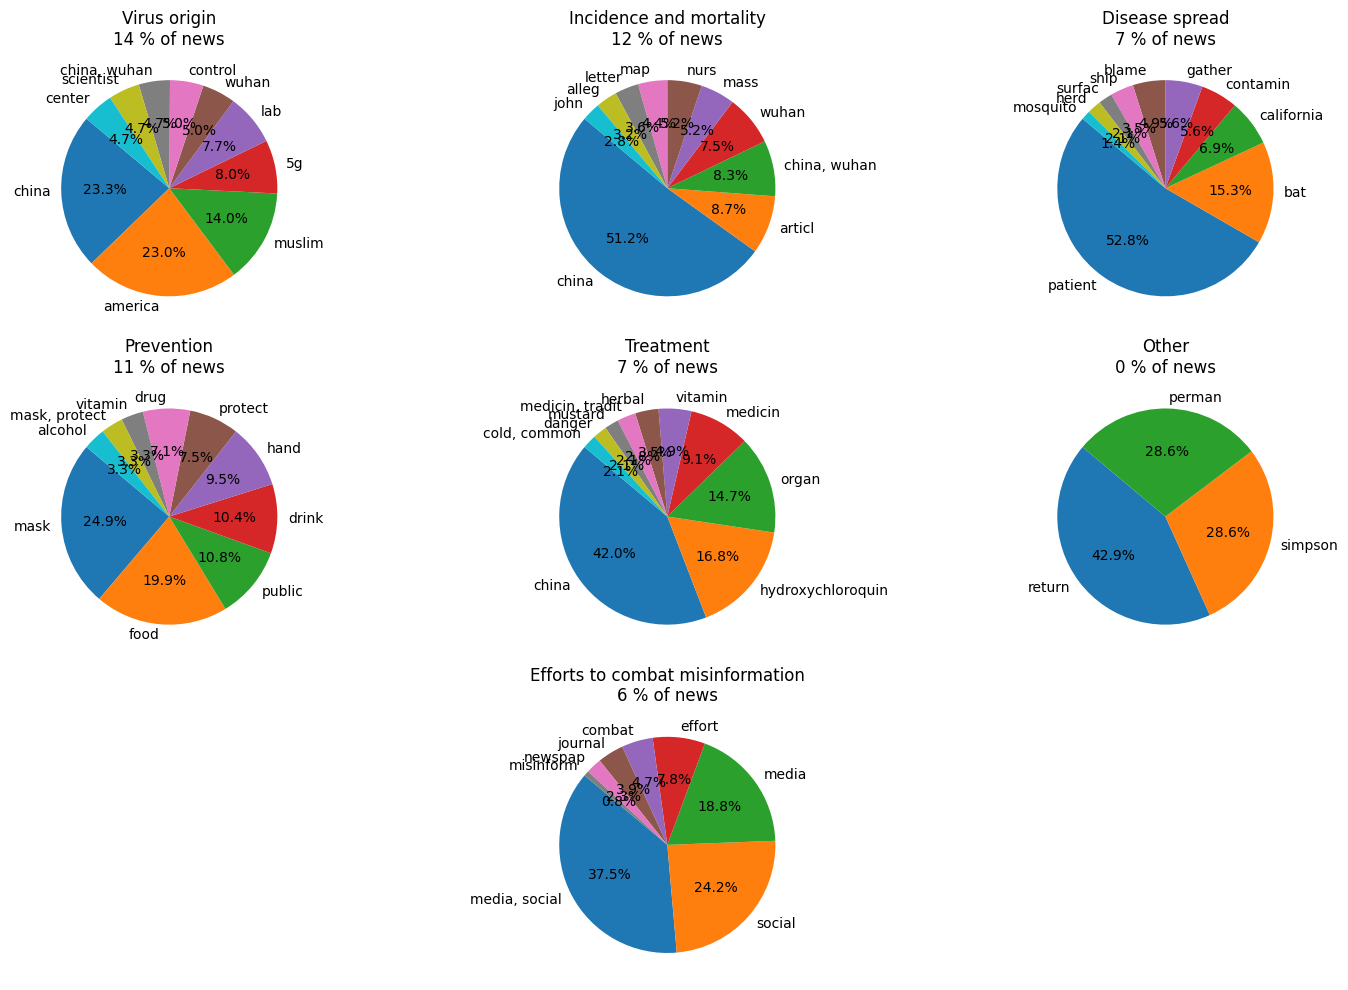

/var/folders/bk/g6m8zp7s30jff72c3nw0kk500000gn/T/ipykernel_58084/4207121521.py:24: MatplotlibDeprecationWarning: normalize=None does not normalize if the sum is less than 1 but this behavior is deprecated since 3.3 until two minor releases later. After the deprecation period the default value will be normalize=True. To prevent normalization pass normalize=False 
  axes[row, col].pie(subcategory_counts, labels=subcategory_counts.index, autopct='%1.1f%%', startangle=140)


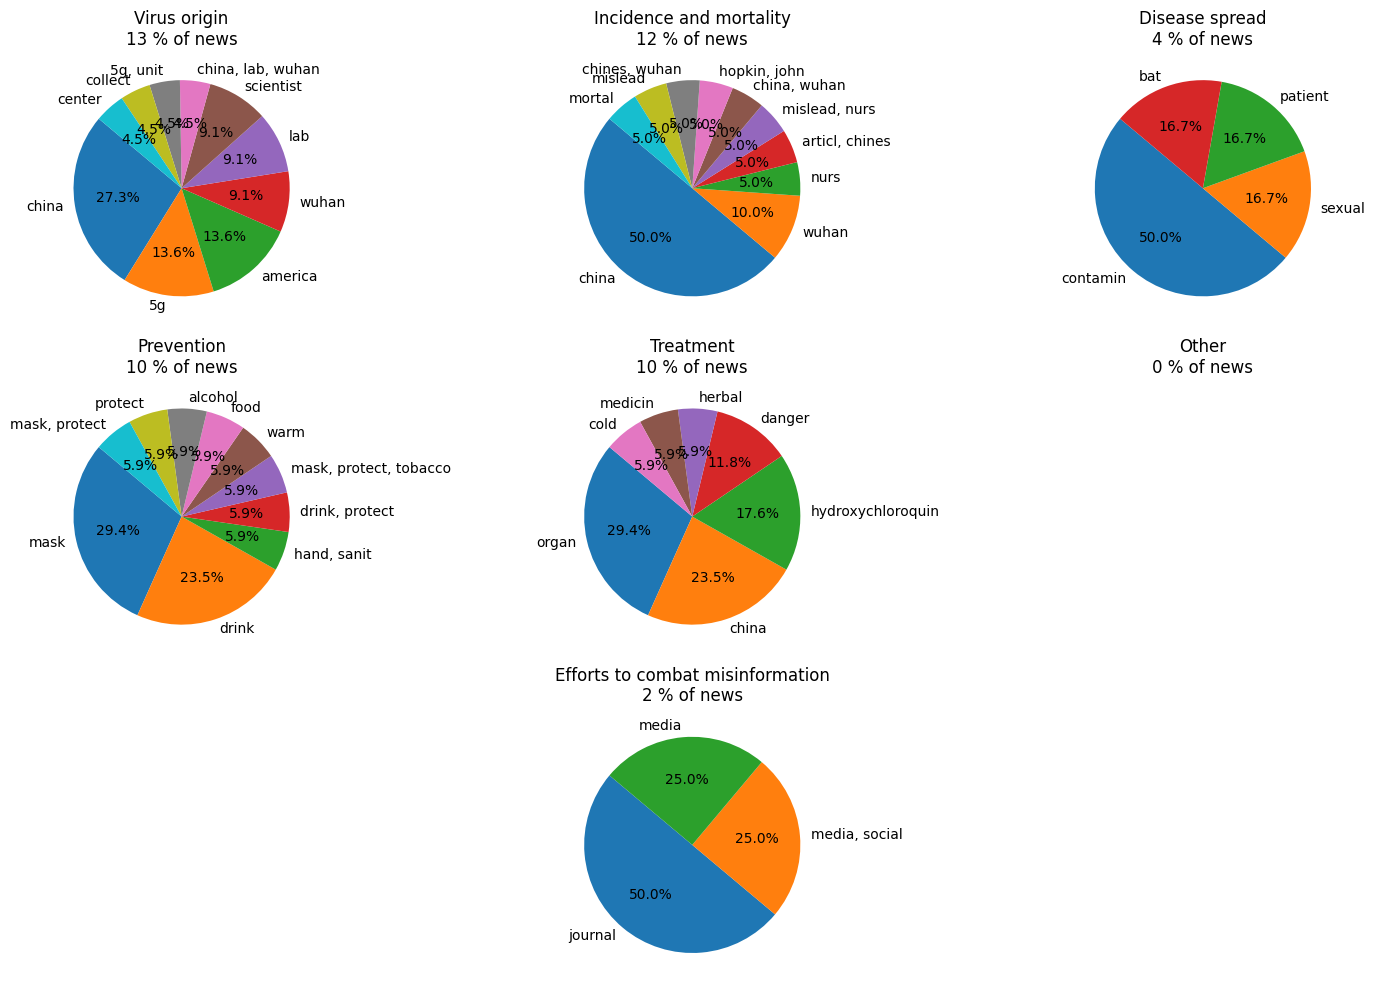

In [24]:
#Plot pie charts

plot_subcategory_pie(subcategory_counts_by_heading_eng, tot_news_eng)
plot_subcategory_pie(subcategory_counts_by_heading_fr, tot_news_fr)
#plot_subcategory_pie(subcategory_counts_by_heading_it, tot_news_it)
#plot_subcategory_pie(subcategory_counts_by_heading_es, tot_news_es)

In [ ]:
# Extract subcategories for each main heading from clustered dfs
eng_subcategories_by_heading = filtered_df_eng.groupby('Main heading')['Subcategory'].apply(set).to_dict()
fr_subcategories_by_heading = filtered_df_fr.groupby('Main heading')['Subcategory'].apply(set).to_dict()
it_subcategories_by_heading = filtered_df_eng.groupby('Main heading')['Subcategory'].apply(set).to_dict()
es_subcategories_by_heading = filtered_df_fr.groupby('Main heading')['Subcategory'].apply(set).to_dict()

# Arrange Venn diagrams in a 2x3 matrix
fig, axes = plt.subplots(nrows=2, ncols=3, figsize=(15, 10))
fig.subplots_adjust(hspace=0.5, wspace=0.5)

# Counter for subplot position
row, col = 0, 0

# Iterate over main headings
for heading in set(eng_subcategories_by_heading.keys()).intersection(fr_subcategories_by_heading.keys()):
    eng_subcategories = eng_subcategories_by_heading[heading]
    fr_subcategories = fr_subcategories_by_heading[heading]

    # Check if both sets are not empty
    if eng_subcategories and fr_subcategories:
        # Calculate Jaccard similarity and overlap percentage
        jaccard_sim= jaccard_similarity(eng_subcategories, fr_subcategories)
        #overlap_percentage = len(eng_subcategories.intersection(fr_subcategories)) / len(eng_subcategories) * 100

        # Create Venn diagram
        venn2([eng_subcategories, fr_subcategories], set_labels=('English', 'French'), ax=axes[row, col])
        axes[row, col].set_title(f'{heading}\nOverlap: {jaccard_sim:.2f}')

        # Update subplot position
        col += 1
        if col == 3:
            col = 0
            row += 1
    else:
        print(f"Skipping '{heading}': One or both sets are empty.")

plt.show()
